<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista2_ARCH_GARCH_BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install statsmodels

In [ ]:
!pip install arch

In [ ]:
!pip install statsforecast

# Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from arch import arch_model


from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [ ]:
start_date = datetime(2018, 1, 1)
end_date = datetime (2022, 6, 30)
#start_date = datetime(2007, 3, 18)
#end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()

#df = np.log(df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

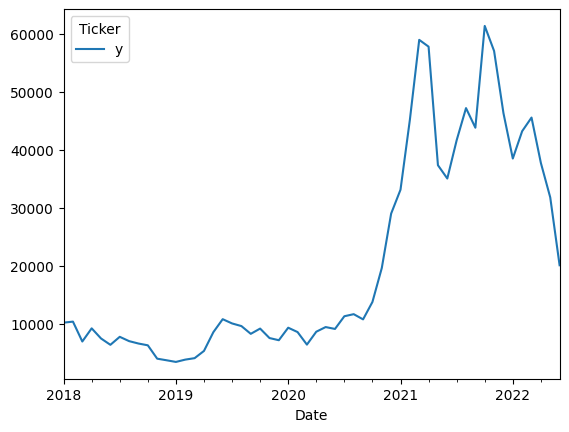

In [ ]:
df.plot()

# Train / Test

In [ ]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)
train.head()

(37, 1)
(17, 1)


Ticker,y
Date,
2018-01-31,10221.099609
2018-02-28,10397.900391
2018-03-31,6973.529785
2018-04-30,9240.549805
2018-05-31,7494.169922


<Axes: title={'center': 'TRAIN'}, xlabel='Date'>

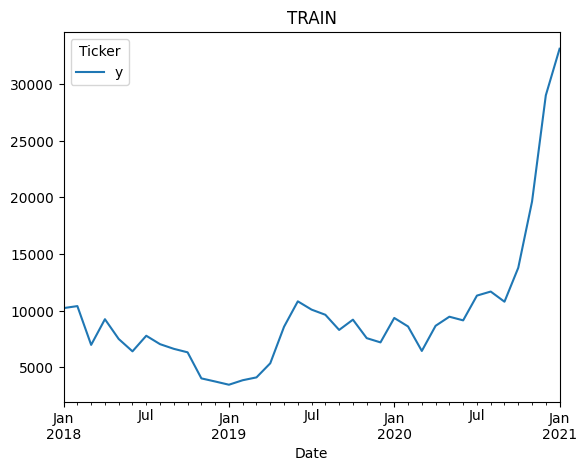

In [ ]:
train.plot(title='TRAIN')

<Axes: title={'center': 'TEST'}, xlabel='Date'>

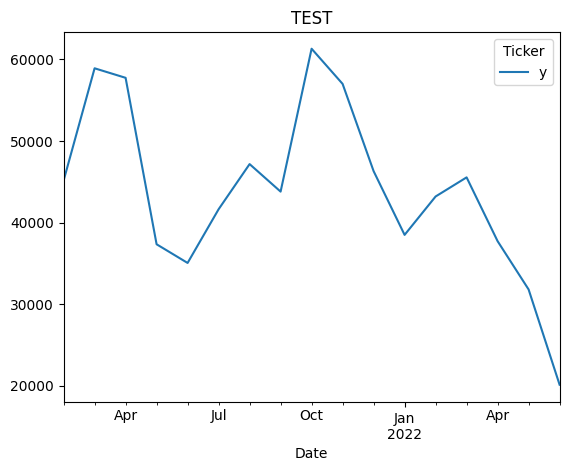

In [ ]:
test.plot(title='TEST')

# Analysis

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    dftest = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(dftest[0:4],index=labels)

    for key,val in dftest[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
p = 2
d = 2
q = 1

arima_mdl = ARIMA(train, order=(p, d, q)).fit()

mean_forecast = arima_mdl.forecast(steps=h)

In [ ]:
arima_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -316.211
Date:                Wed, 16 Apr 2025   AIC                            640.422
Time:                        11:32:46   BIC                            646.643
Sample:                    01-31-2018   HQIC                           642.570
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7275      0.248     -2.928      0.003      -1.214      -0.241
ar.L2         -0.5332      0.181     -2.950      0.003      -0.887      -0.179
ma.L1          0.4862      0.262      1.858      0.063      -0.027       0.999
sigma2       4.08e+06   1.05e+06      3.894      0.000    2.03e+06    6.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.54   Prob(JB):                         0.59
Heteroskedasticity (H):               3.47   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Intervalos de confiança dos parâmetros
conf_int = arima_mdl.conf_int()
print(conf_int.T)  # Transpõe para ficar igual ao R

      ar.L1     ar.L2     ma.L1        sigma2
0 -1.214418 -0.887400 -0.026705  2.026719e+06
1 -0.240584 -0.178926  0.999071  6.133484e+06


In [ ]:
arima_resid = arima_mdl.filter_results.standardized_forecasts_error[0]#resid
print(arima_resid)

[ 3.6830555  -2.80651065 -1.55053552  0.13796851 -0.94407463  0.83504958
 -0.00703421  0.01580701  0.04387713 -0.41004447 -0.6622042   0.63473203
 -0.11000291  0.92205074 -0.27788475  0.75481876  0.93210691  0.03622127
 -1.32117759 -0.55090441 -0.85415859  1.28086971 -1.30315906  0.93301323
  0.58269286 -0.4796755  -0.84351219  1.30354942 -0.12981656  0.15169858
  0.38862909 -0.48760341 -0.37987958  1.1778421   1.9086119   2.873554
 -1.97916402]


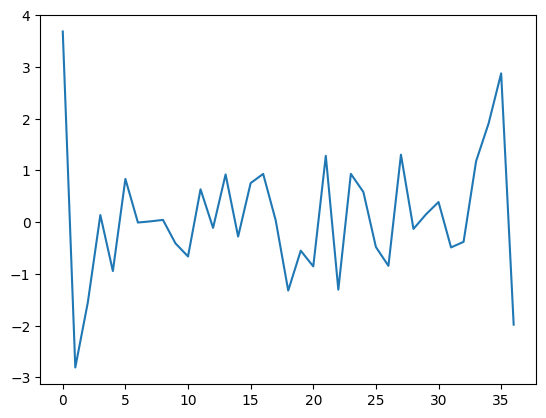

In [ ]:
plt.plot(arima_resid)

In [ ]:
adf_test(pd.Series(arima_resid))

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.645160e+00
p-value                 1.850992e-11
# lags used             0.000000e+00
# observations          3.600000e+01
critical value (1%)    -3.626652e+00
critical value (5%)    -2.945951e+00
critical value (10%)   -2.611671e+00
Reject the null hypothesis
Data has no unit root and is stationary


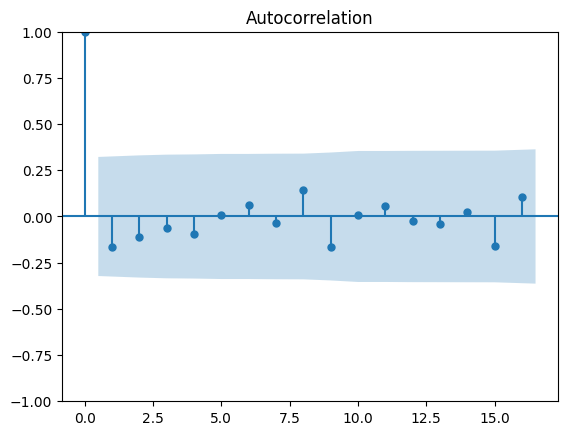

In [ ]:
fig = plot_acf(arima_resid)

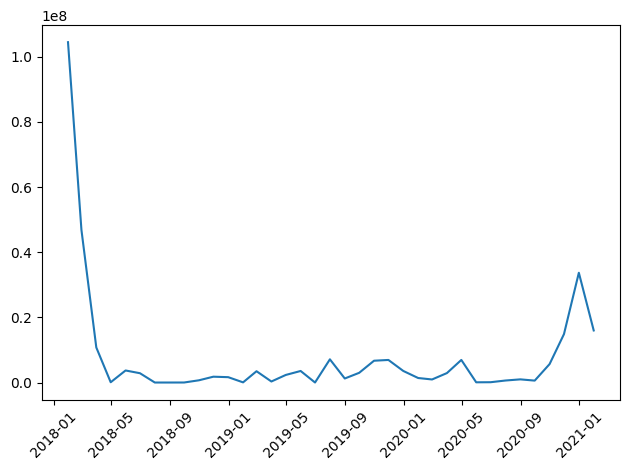

In [ ]:
sq_arima_resid = (arima_mdl.resid**2).dropna()
plt.plot(sq_arima_resid)
plt.xticks(rotation=45)  # ou 60 se necessário
plt.tight_layout()
plt.show()

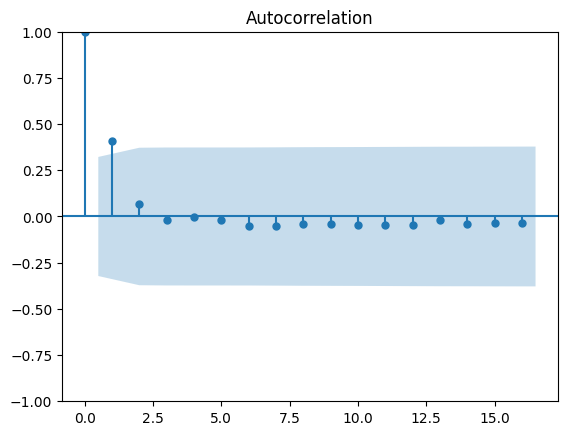

In [ ]:
fig = plot_acf(sq_arima_resid)

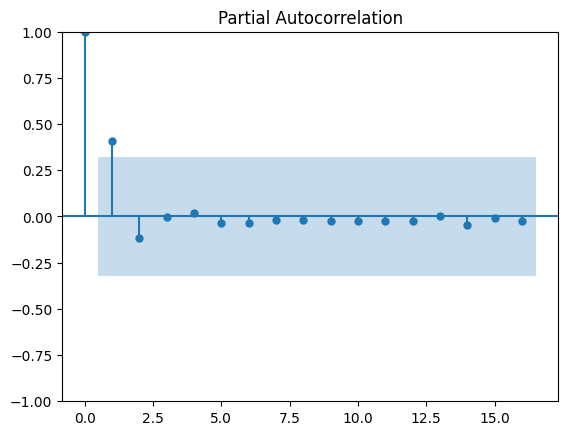

In [ ]:
fig2 = plot_pacf(sq_arima_resid)

#ARCH

## ARCH(1)

In [ ]:
# Ajustar ARCH nos resíduos
arch1_mdl = arch_model(arima_resid, vol='ARCH', p=1, rescale=False)
arch1_fit = arch1_mdl.fit(disp='off')

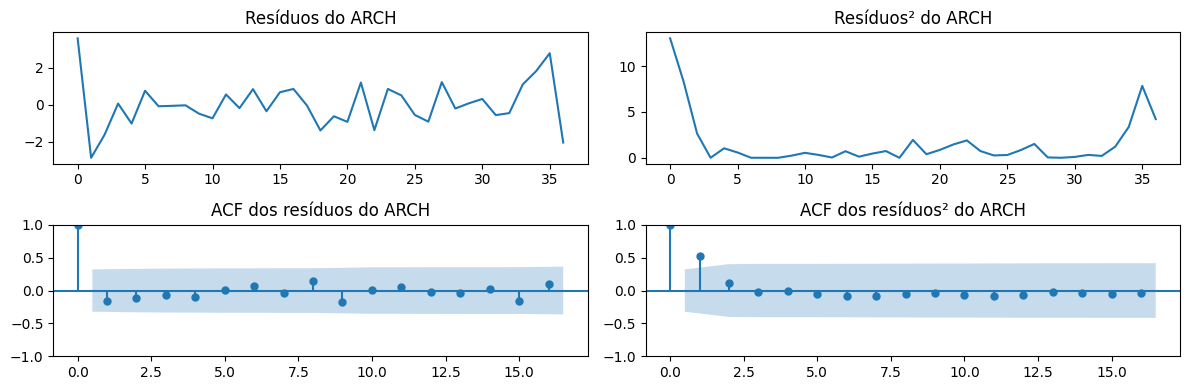

In [ ]:
arch_resid = arch1_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 4))

axes[0,0].plot(arch_resid)
axes[0,0].set_title("Resíduos do ARCH")

plot_acf(arch_resid, ax=axes[1,0])
axes[1,0].set_title("ACF dos resíduos do ARCH")

axes[0,1].plot(arch_resid**2)
axes[0,1].set_title("Resíduos² do ARCH")

plot_acf(arch_resid**2, ax=axes[1,1])
axes[1,1].set_title("ACF dos resíduos² do ARCH")

plt.tight_layout()
plt.show()

Se o resíduo ao quadrado do modelo possuir autocorrelação, isso indica que não foi encontrado um treinamento satisfatório ou, em outras palavras, que o modelo não foi capaz de capturar as caracterísitcas da série temporal.

In [ ]:
conf_int = arch1_fit.conf_int()
print(conf_int.T)  # Transpor como em R

             mu     omega  alpha[1]
lower -0.131512  0.139509  0.152914
upper  0.280158  0.692498  1.462772


In [ ]:
print(arch1_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -52.7073
Distribution:                  Normal   AIC:                           111.415
Method:            Maximum Likelihood   BIC:                           116.247
                                        No. Observations:                   37
Date:                Wed, Apr 16 2025   Df Residuals:                       36
Time:                        11:49:43   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0743      0.105      0.708      0.479 [ -0.132,  0.28

## Forecast

In [ ]:
arch_fit = arch1_fit

Previsão da volatilidade

In [ ]:
arch_result  = arch_fit.forecast(horizon=h).variance
print(arch_result)

        h.01      h.02      h.03      h.04      h.05      h.06      h.07  \
36  3.822525  3.504004  3.246689  3.038819  2.870893  2.735235  2.625644   

        h.08      h.09      h.10      h.11      h.12      h.13      h.14  \
36  2.537112  2.465592  2.407815  2.361141  2.323435  2.292975  2.268367   

        h.15     h.16      h.17  
36  2.248489  2.23243  2.219457  


Visualização do gráfico hedgehog

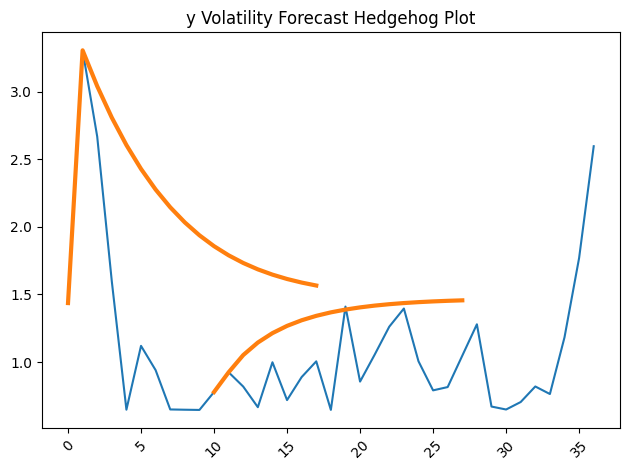

In [ ]:
fig = arch_fit.hedgehog_plot(horizon=h)
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x
plt.tight_layout()
plt.show()

## Confidence Interval

Usando o ARCH para definir o intervalo de confiança das previsões do ARIMA.

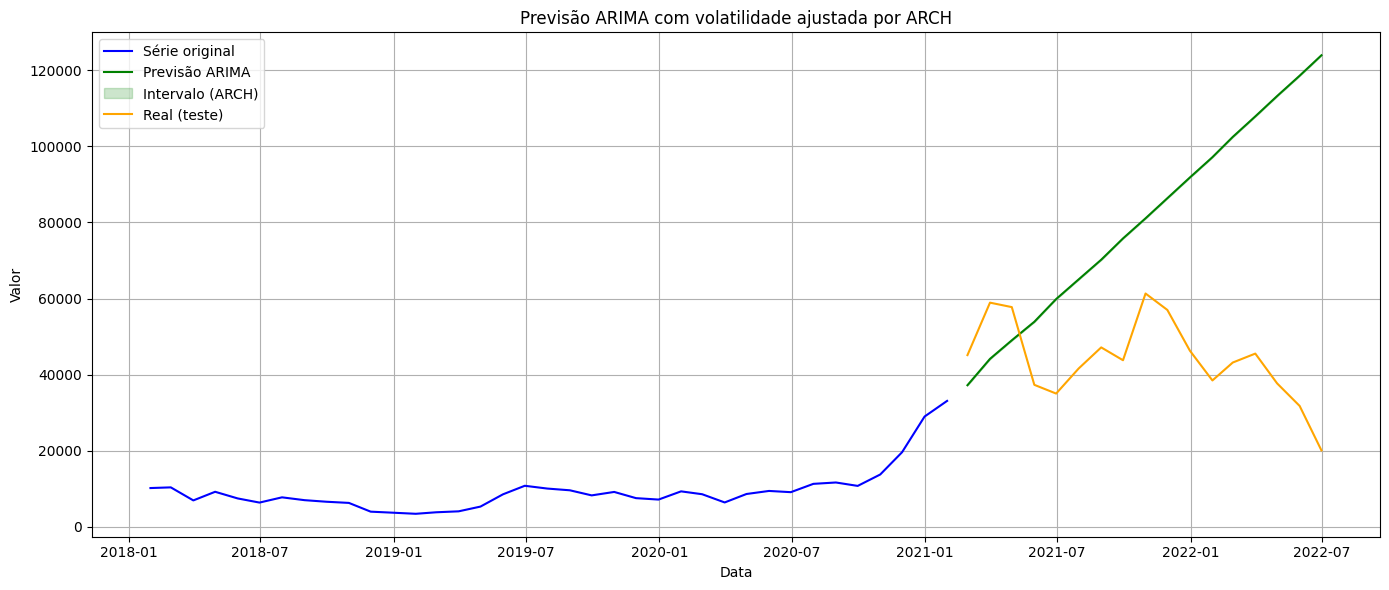

In [ ]:
arch_pred = arch_result.values[0]
std_forecast = np.sqrt(arch_pred)  # desvio padrão

inferior = mean_forecast - std_forecast
superior = mean_forecast + std_forecast


# Plotando o gráfico
plt.figure(figsize=(14,6))
plt.plot(train, label='Série original', color='blue')
plt.plot(test.index, mean_forecast, label='Previsão ARIMA', color='green')
plt.fill_between(test.index, inferior, superior, color='green', alpha=0.2, label='Intervalo (ARCH)')
plt.plot(test, label='Real (teste)', color='orange')
plt.title('Previsão ARIMA com volatilidade ajustada por ARCH')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulation

[1.95512781 1.87189851 1.80185717 1.74322094 1.69437094 1.65385451
 1.62038397 1.59283152 1.57022046 1.5517137  1.53660038 1.52428177
 1.51425709 1.50611    1.4994961  1.49413173 1.48978405]
[-1.37856867  1.51462584  0.63989897 -1.58944683  1.07236311 -0.10028529
 -1.15638654  1.1852487  -1.08932506 -0.55249811 -1.44451117  1.41910853
 -1.14188581  0.59171802  1.33807738 -1.0486185   0.78165627]


<Axes: xlabel='Date'>

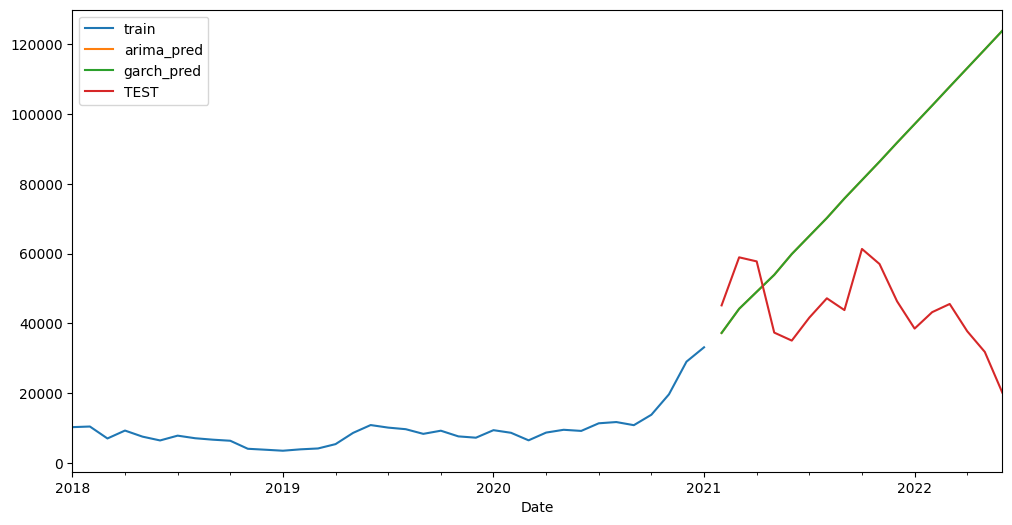

In [ ]:
random_values = np.random.uniform(low=-std_forecast, high=std_forecast)
#random_values = np.random.normal(loc=0, scale=std_forecast)
print(std_forecast)
print(random_values)
simulated_return = mean_forecast + random_values

#Plotando as previsões
train['y'].plot(legend=True, label='train')
mean_forecast.plot(legend=True, label='arima_pred')
simulated_return.plot(legend=True, label='garch_pred', figsize=(12, 6))
test['y'].plot(legend=True, label='TEST')

# GARCH

## Garch(1,1)

In [ ]:
# Ajustar GARCH(1,1) nos resíduos
garch11_mdl= arch_model(arima_resid, vol='GARCH', p=1, q=1, rescale=False)
garch11_fit = garch11_mdl.fit(disp='off')


In [ ]:
conf_int = garch11_fit.conf_int()
print(conf_int.T)  # Transpor como em R

             mu     omega  alpha[1]   beta[1]
lower -0.105568 -0.002684  0.112494  0.005444
upper  0.279136  0.520373  1.472788  0.283655


In [ ]:
print(garch11_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -52.4090
Distribution:                  Normal   AIC:                           112.818
Method:            Maximum Likelihood   BIC:                           119.262
                                        No. Observations:                   37
Date:                Wed, Apr 16 2025   Df Residuals:                       36
Time:                        11:49:45   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0868  9.814e-02      0.884      0.377 [ -0.106,  0.27

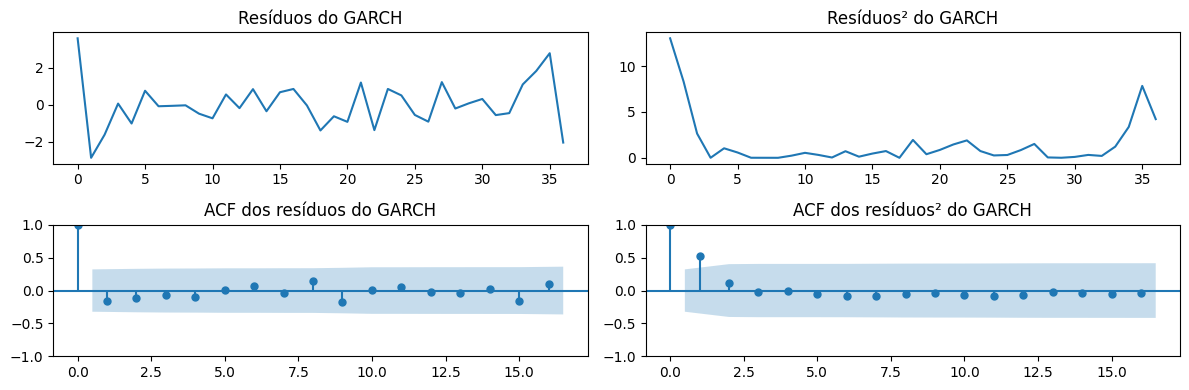

In [ ]:
garch_resid = garch11_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 4))

axes[0,0].plot(arch_resid)
axes[0,0].set_title("Resíduos do GARCH")

plot_acf(arch_resid, ax=axes[1,0])
axes[1,0].set_title("ACF dos resíduos do GARCH")

axes[0,1].plot(arch_resid**2)
axes[0,1].set_title("Resíduos² do GARCH")

plot_acf(arch_resid**2, ax=axes[1,1])
axes[1,1].set_title("ACF dos resíduos² do GARCH")

fig.tight_layout()
fig.show()

Se o resíduo ao quadrado do modelo possuir autocorrelação, isso indica que não foi encontrado um treinamento satisfatório ou, em outras palavras, que o modelo não foi capaz de capturar as caracterísitcas da série temporal.

## Forecast

In [ ]:
garch_fit = garch11_fit

Previsão da volatilidade

In [ ]:
arch_result  = arch_fit.forecast(horizon=h).variance
print(arch_result)

        h.01      h.02      h.03      h.04      h.05      h.06      h.07  \
36  3.822525  3.504004  3.246689  3.038819  2.870893  2.735235  2.625644   

        h.08      h.09      h.10      h.11      h.12      h.13      h.14  \
36  2.537112  2.465592  2.407815  2.361141  2.323435  2.292975  2.268367   

        h.15     h.16      h.17  
36  2.248489  2.23243  2.219457  


Visualização do gráfico hedgehog

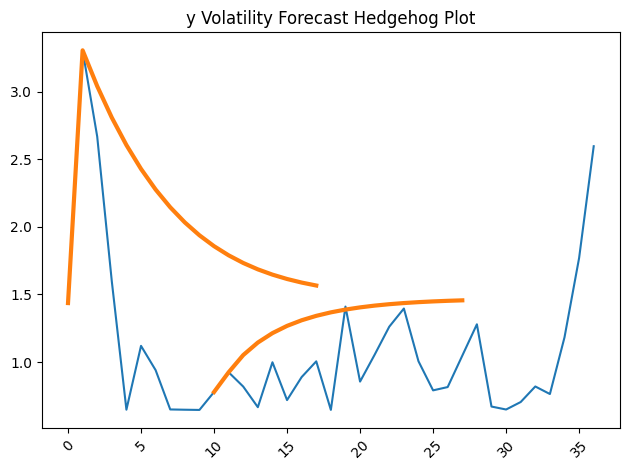

In [ ]:
fig = arch_fit.hedgehog_plot(horizon=h)
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x
plt.tight_layout()
plt.show()

## Confidence Interval

superior.head()=2021-02-28    37231.899406
2021-03-31    44151.447659
2021-04-30    49029.495974
2021-05-31    53897.659277
2021-06-30    59861.467085
Freq: ME, Name: predicted_mean, dtype: float64
mean_forecast.head()=2021-02-28    37229.746871
2021-03-31    44149.302612
2021-04-30    49027.357967
2021-05-31    53895.527890
2021-06-30    59859.341920
Freq: ME, Name: predicted_mean, dtype: float64
inferior.head()=2021-02-28    37227.594337
2021-03-31    44147.157565
2021-04-30    49025.219961
2021-05-31    53893.396504
2021-06-30    59857.216756
Freq: ME, Name: predicted_mean, dtype: float64


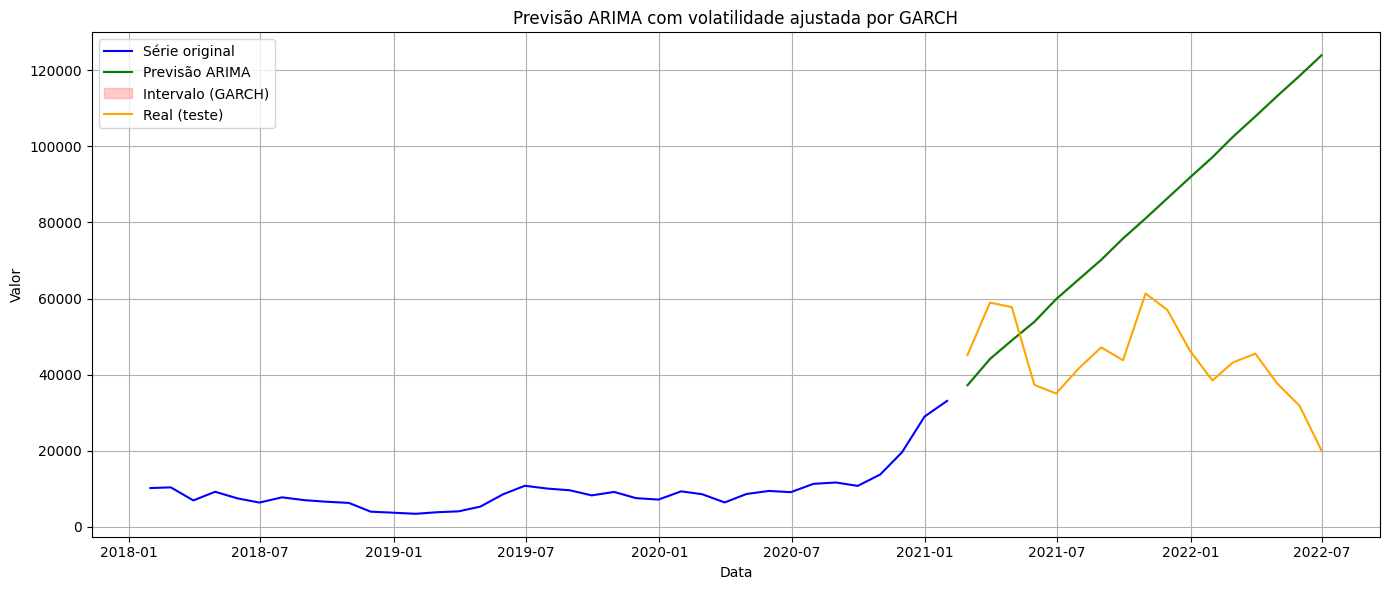

In [ ]:

garch_pred = garch_fit.forecast(horizon=h).variance.values[0]
std_forecast = np.sqrt(garch_pred)  # desvio padrão

inferior = mean_forecast - std_forecast
superior = mean_forecast + std_forecast
print(f'superior.head()={superior.head()}')
print(f'mean_forecast.head()={mean_forecast.head()}')
print(f'inferior.head()={inferior.head()}')

# Plotando o gráfico
plt.figure(figsize=(14,6))
plt.plot(train, label='Série original', color='blue')
plt.plot(test.index, mean_forecast, label='Previsão ARIMA', color='green')
plt.fill_between(test.index, inferior, superior, color='red', alpha=0.2, label='Intervalo (GARCH)')
plt.plot(test, label='Real (teste)', color='orange')
plt.title('Previsão ARIMA com volatilidade ajustada por GARCH')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulation

[2.15253465 2.14504735 2.13800652 2.13138682 2.12516417 2.11931578
 2.11382003 2.10865647 2.10380572 2.09924947 2.0949704  2.09095215
 2.08717926 2.08363714 2.08031202 2.07719092 2.07426159]
[-1.50849888  0.05816732  1.01000896 -1.77958628 -0.09483765  0.72730245
  0.7612206   1.54234258  0.82703933  0.37598732  1.00380949 -0.48613262
  0.97629624  0.72214446  1.17340856  0.78368636  0.79068219]


<Axes: xlabel='Date'>

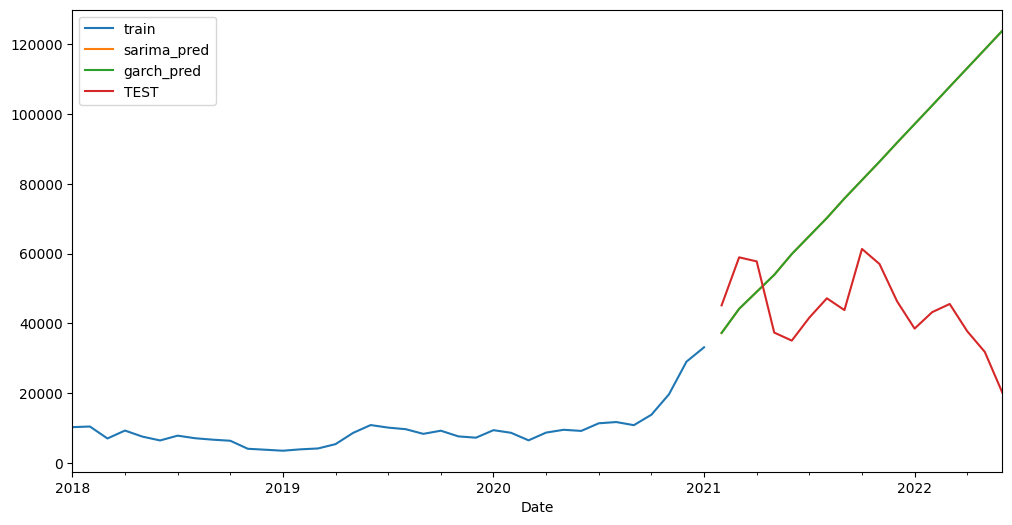

In [ ]:
random_values = np.random.uniform(low=-std_forecast, high=std_forecast)
#random_values = np.random.normal(loc=0, scale=std_forecast)
print(std_forecast)
print(random_values)
simulated_return = mean_forecast + random_values

#Plotando as previsões
train['y'].plot(legend=True, label='train')
mean_forecast.plot(legend=True, label='sarima_pred')
simulated_return.plot(legend=True, label='garch_pred', figsize=(12, 6))
test['y'].plot(legend=True, label='TEST')